# Compression of generative art videos: h264, h265, VP8/9, AV1

We'll be analyzing a practical use case, video compression of Processing or P5js sketches with FFMPEG and h264 AVC, h265 HEVC, VP8 and VP9, and AV1 codecs.

## Encoder choices

For h264, we'll be using libx264, though we can also use NVenc and kvazaar. For h265 we'll be using libx265, but NVenc is also a possibility.
VP8 and VP9 are provided via libvpx and libvpx-vp9 and finally AV1 support is provided via libaom-av1.
For h266 we don't have yet FFMPEG support, but we can use the reference h266/VVC encoder and decoders, however FFMPEG has no player support yet, nor metrics analysis support. The state of VVC is too experimental and rough at this stage in order to do a confident analysis of results.
MPEG5 EVC has experimental support in a separate FFMPEG fork, but this also requires considerable detours and brings the inability to do a direct analysis of results. 
This document however will be updated at a later date with MPEG5 EVC tests and VVC/h.266 tests as they evolve.

## Test Content

The creation of relevant good quality meaningful reference material for video compression testing is on itself a challenge due to the incredible number of options, parameters, use cases that need to be covered. What is good quality? Good quality on a 1m diagonal OLED display? Or on your mobile phone?
Is the content being streamed? Is latency critical? Or is the content stored offline, i.e, in a disc?
Settings that will work great with normal scenes will fail with high motion scenes.

Due to the countless encoding options and the combinatorial explosion of testing them all, we'll be focusing on a narrow subset of options targetting this specific use case - generative art videos which exhibit the following characteristics

 * Fast erratic or unpredictable movement
 * No motion blur
 * High frequency content, in some cases, with aliasing
 * High chromatic contrast and color purity
 * Cases with overlapping alpha blended unpredictable movement
 
Together with these test results, notebooks and source code you'll also find the source code for the P5js sketches that were specifically created as reference source material in order to test our use cases on [on the github repository](https://github.com/luisbarrancos/generative-o-matic/tree/master/P5js) that also contains these notebooks.

The sketches were recorded and encoded with NVidia's [hevc_nvenc](https://docs.nvidia.com/video-technologies/video-codec-sdk/nvenc-video-encoder-api-prog-guide/) using the GPU to keep the high throughput low latency required to record the processing intensive sketches without the introduction of lag.

## Reference Material Encoding and Characteristics

The source material was encoded with h265/HEVC lossless profile, intra frames only, with YUV 4\:4\:4 sampling, high tier mode to have good reference material attending the characteristics outlined above.
If needed, you can change the profile to a 10 or even 12bit profile. For these tests we remain with 8bit output.
Colorimetry was set to Rec.709 RGB primaries, D65 whitepoint, but with the sRGB IEC-61922-6.1 EOTF.

## Types of Video Quality Metrics

Like with the creation of meaningful content for tests, the metrics used are and have been an area of active and ongoing research for quite some time. Both content and video quality assessment are actives areas of research under several groups, including the [VQEG or Video Quality Experts Group](https://www.its.bldrdoc.gov/vqeg/vqeg-home.aspx). We cannot cover all of this in-depth but we'll provide a brief assessment of the main families of techniques and the ones we'll be using in the tests that we'll be running.

Succintly, there are **objective** and **subjective** quality models. Objective models can be measured free from human interpretation, and can be divided according to what signal we have available to test.
Subjective models requires the viewers opinion of the quality of the video being watched and a mean score given.


### Full Reference Methods

This method compares the encoded signal with a original reference signal and quantifies the difference according to specific metrics. Since they require both the original and the compressed signals, they cannot be used everywhere and since they measure pixel differences, there is heavy computational cost involved.

### Reduced Reference Methods

Similar to the [**Full Reference Method**](#Full-Reference-Method), except there's no access to the entire original signal, or due to constraints, it's impractical to acess it all.

### No Reference Methods

Are used to assign a quality indication of the compressed signal without access to the original material. They are usually lighter to compute. 
These are divided into
 * **Pixel Based Methods** - try to quantify the image quality or degradation due to blurring, motion blur, other artifacts
 * **Parametric or Bitstream Methods** - these have access to encoding data, parameters, motion vectors and other related data and try to access the signal quality according to these. They're not accurate, but provide a good fast approximated indication.
 * **Hybrid Methods** - combine both the pixel based methods and the parametric or bitstream methods.
 

## Methodology

### Video Quality Metrics Used

Since we have access to the original source material and the compressed material we'll be generating, and performance is not critical, it makes sense to use full reference methods.
Of these, the metrics we'll be using are:

 * [**PSNR**](https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio) - Peak Signal to Noise Ratio. Due to the characteristics of the HVS, PSNR is not a reliable indicator of perceived quality.
 * [**SSIM**](https://en.wikipedia.org/wiki/Structural_similarity) - Structural Similarity. SSIM measures perceived change in structural information, including luminance and contrast masking, it takes the HVS characteristics into consideration and is a more reliable indicator of perceived quality than PSNR.
 * [**VMAF**](https://github.com/Netflix/vmaf) - Video Multimethod Assessment Fusion, is a metric developed by NetFlix, composed of 4 distinct features which are fused via SVM or Suport Vector Machine, a type of supervised machine learning model used for data classification and regression analysis. These features are:
   * [**VIF**](https://en.wikipedia.org/wiki/Visual_information_fidelity) or Visual Information Fidelity, which considers information loss in 4 different spatial scales
   * DLM or Detail Loss Metric, measures loss of details
   * MCPD or Mean Co-located Pixel Difference, measures the temporal difference on the luminance component
   * ANSNR or Anti-Noise Signal-to-Noise Ratio, abandoned in new VMAF versions.
 
#### Other AI/ML Methods for Video Quality Assessment

We'll also be using at a later stage AI/ML for perceptual video quality assessment methods with [LPIPS](https://richzhang.github.io/PerceptualSimilarity/) metric - Learned Perceptual Image Patch Similarity, and with the [Berkeley-Adobe Perceptual Patch Similarity (BAPPS) dataset](https://github.com/richzhang/PerceptualSimilarity#2-berkeley-adobe-perceptual-patch-similarity-bapps-dataset), albeit in a randomized set of static frames, as well as PSNR-HVS-M, that is, Peak Signal To Noise Ratio taking into account Contrast Sensitivity Function (CSV) and in-between coefficient contrast masking of DCT basis functions - a PSNR metric that takes into account the HVS response.

### Encoding Options Used

As outlined earlier, we'll be restricting the options to the choice of:
 * presets
 * tuning
 * entropy encoding algorithms
 * rate control types
 * chroma subsampling
 
There are countless options to fine-tune the motion vector search algorithms, macroblocks sizes, and so on, but this would lead to thousands of files. It can be done, but in a automated, machine-assisted way that is outside the scope of this report.

---

These will **not** be used on all codecs since some features are only available or exposed to the end user in some codecs, and it would be a daunting task to establish mappings between most parameters.
This being said however, by default most codecs seem to a common setting for presets, determining the amount of resources to allocate to compression and most common options hidden behind a preset configuration.
They also have in common the **CRF** or Constant Rate Factor, that adapts the data rate in order to target a quality level.
These are in common with x264, x265, vpx (VP8) and vpx-vp9 (VP9), ranging from 0 to 51, where higher values mean higher compression.
Some also have exposed a **QP** or *Quantization Parameter* control, that allows one to specify the amount of compression for every macroblock in a frame, with higher values resulting in higher quantization, and therefore more compression.

Control over CRF and QP is also exposed in an experimental VVC/h.266 encoder, as well as on a test implementation of [MPEG5 EVC](https://en.wikipedia.org/wiki/Essential_Video_Coding) in FFMPEG via the [XEVE library](https://github.com/mpeg5/xeve) but these are left outside the scope of this document until a later date.


---

#### Encoding Entropy Algorithm *(coder)* can be one of

* [CABAC](https://en.wikipedia.org/wiki/Context-adaptive_binary_arithmetic_coding) - Context Adaptive Binary Arithmetic Coding
 * [CAVLC](https://en.wikipedia.org/wiki/Context-adaptive_variable-length_coding) - Context Adaptive Variable Length Encoding
 * [AC](https://en.wikipedia.org/wiki/Arithmetic_coding) - Arithmetic Coding
 * [VLC](https://en.wikipedia.org/wiki/Variable-length_code) - Variable Lenght Encoding

See [also this](https://learn.akamai.com/en-us/webhelp/media-services-on-demand/media-services-on-demand-encoder-best-practices/GUID-F3F0BD92-69C3-4B7F-BE84-A33BA138B55A.html)

#### Rate control, can be one of

 * ConstQP - Constant Quantization P mode
 * [VBR](https://en.wikipedia.org/wiki/Variable_bitrate) - Variable Bit Rate
 * [CBR](https://en.wikipedia.org/wiki/Constant_bitrate) - Constant Bit Rate
 * CBR_LD_HQ - Constant Bit Rate with Low Delay, High Quality mode
 * CBR_HQ - Constant Bit Rate High Quality Mode
 * VBR_HQ - Variable Bit Rate High Quality Mode

#### [Chroma subsampling](https://en.wikipedia.org/wiki/Chroma_subsampling)

Can be YUV 4\:2\:0, 4\:2\:2, 4\:4\:4. The libx264 codec has more control over the macroblocks when compared with NVenc. Other codecs support other sampling modes, such as YUV 4\:1\:1, and quantization modes for 10bit, 12bit, 16bit signals, besides RGB.

---

##### Definitions Y versus Y\': Relative Luminance Y

Relative luminance Y as defined by the CIE refers to a weighted sum of coefficients provided by the color matching functions and the RGB primaries of the color space of the signal. It is a linear quantity or **scene-linear**, in that there is no color component transfer function assigned to it in order to compensate for the characteristics of the human visual system.

##### Definitions Y versus Y\': Luma Y' or Y prime

In order to differentiate relative luminance from a signal with color component transfer function attached, such as a simple power function with a *gamma* exponent it was decided to differentiate the luminance Y used in colorimetry from the luminance used in video, by naming it instead **luma**, and assigning it the designation **Y/'** or Y prime, which is also documented under the [SMPTE Engineering Guideline Annotated Glossary of Essential Terms for Electronic Production](https://ieeexplore.ieee.org/document/7291332).
In real life however, when referring to video, it's rarely seen the use the **Y\'** instead of **Y**, but we're referring to the *gamma compressed* **luma Y\'** here.

See also [YUV and Luminance Considered Harmful](https://poynton.ca/PDFs/YUV_and_luminance_harmful.pdf)

---


In [1]:
#!ffmpeg -h encoder=libx264

## Video resources, configuration

Start by defining a **VIDEO_RESOURCES** environment variable pointing to the location of your original videos, and **VIDEO_COMPRESSED** environment variable pointing to the location to use for storing the resulting compressed videos.

In [51]:
import media as md
import options as op
import os

### Create a new Media object

A media class was created [accessible here, media.py](./media.py) to encapsulate the options used for each encoder in order to automate the creation of compressed output.
You can import the object and check its built-in help and methods in Python in the following snippet:
```python
import media as md
media = md.Media()
# help on the class
help(md)
# methods available
dir(md)
```


In [52]:
media = md.Media()

In [4]:
print(f"source material dir:\n{media.input_dir},\noutput dir:\n{media.output_dir}") 

source material dir:
/home/cgwork/Downloads/Masters/Tecnologias_Comunicacao_Multimedia_TCM/Work/videos/original,
output dir:
/home/cgwork/Downloads/Masters/Tecnologias_Comunicacao_Multimedia_TCM/Work/videos/compressed


We'll glob all the files under the input dir with the following extensions (the following containers)

In [5]:
print(media.containers())

['mp4', 'mkv', 'webm']


The source material that we'll be using is

In [6]:
media.glob_media()
media.input_files()

['/home/cgwork/Downloads/Masters/Tecnologias_Comunicacao_Multimedia_TCM/Work/videos/original/light_orbitals.mkv',
 '/home/cgwork/Downloads/Masters/Tecnologias_Comunicacao_Multimedia_TCM/Work/videos/original/colored_orbitals.mkv',
 '/home/cgwork/Downloads/Masters/Tecnologias_Comunicacao_Multimedia_TCM/Work/videos/original/flowlock.mkv',
 '/home/cgwork/Downloads/Masters/Tecnologias_Comunicacao_Multimedia_TCM/Work/videos/original/flowfield.mkv',
 '/home/cgwork/Downloads/Masters/Tecnologias_Comunicacao_Multimedia_TCM/Work/videos/original/noiseywaves.mkv']

Add your own directory and set the environment variables, and copy the videos you want to analyze there. Ideally, YUV 4\:4\:4 chroma sampling, and with the highest quality possible since these are to be the reference sources against with compressed material is going to be compared.

In [7]:
# same for the output files, but these are the output basenames only, we want the
# qualified output filenames, with the encoded parameters as part of the filename
# media.output_files()

We can view a video thumbnail, for example, the first video in the list

In [8]:
import ffmpeg

from ipywidgets import interact
from matplotlib import pyplot as plt
import ipywidgets as widgets
import numpy as np

### Media information

We'll store the media information in a dictionary to be queried later. Information such as the video stream data, width, height, aspect ratio, pixel format & chroma sampling, color range, color component transfer functions, RGB primaries and whitepoint, frame rate, time base, and so on.

In [9]:
info = media.info()

In [10]:
# get the width and height of the first media file in the input list
width = media.width(media.input_files()[0])
height = media.height(media.input_files()[0])
print(f"input file {media.input_files()[0]} height is {height}, width is {width}")

input file /home/cgwork/Downloads/Masters/Tecnologias_Comunicacao_Multimedia_TCM/Work/videos/original/light_orbitals.mkv height is 720, width is 1280


#### Viewing the Test Clip(s)

Prepare the widget for the thumbnail view with the FFMPEG python bindings and NumPy

In [11]:
out, err = (
    ffmpeg
    .input(media.input_files()[0])
    .output("pipe:", format="rawvideo", pix_fmt="rgb24", loglevel="error")
    .run(capture_stdout = True)
)

video = (
    np
    .frombuffer(out, np.uint8)
    .reshape([-1, height, width, 3])
)

@interact(frame=(0, media.number_of_frames(media.input_files()[0])))
def show_frame(frame = 0):
    plt.imshow(video[frame,:,:,:])

interactive(children=(IntSlider(value=0, description='frame', max=256), Output()), _dom_classes=('widget-inter…

### Available Codecs

We can check codecs with ```ffmpeg -codecs``` and specific options with ```ffmpeg -h encoder=<encoder here>```, example for the h264 case, ```ffmpeg -h encoder=libx264```.
In our case, we're interested in h264, h264/HEVC, h266/VVC, VP8, VP9, AV1.

In [12]:
!ffmpeg -hide_banner -loglevel error -codecs|grep -wE 'av1|vp8|vp9|h264|hevc|vvc'

 DEV.L. av1                  Alliance for Open Media AV1 (decoders: libdav1d libaom-av1 av1 ) (encoders: libaom-av1 libsvtav1 )
 DEV.LS h264                 H.264 / AVC / MPEG-4 AVC / MPEG-4 part 10 (decoders: h264 h264_v4l2m2m h264_cuvid ) (encoders: libx264 libx264rgb h264_nvenc h264_v4l2m2m nvenc nvenc_h264 )
 DEV.L. hevc                 H.265 / HEVC (High Efficiency Video Coding) (decoders: hevc hevc_v4l2m2m hevc_cuvid ) (encoders: libx265 nvenc_hevc hevc_nvenc hevc_v4l2m2m libkvazaar )
 DEV.L. vp8                  On2 VP8 (decoders: vp8 vp8_v4l2m2m libvpx vp8_cuvid ) (encoders: libvpx vp8_v4l2m2m )
 DEV.L. vp9                  Google VP9 (decoders: vp9 vp9_v4l2m2m libvpx-vp9 vp9_cuvid ) (encoders: libvpx-vp9 )
 ..V.L. vvc                  H.266 / VVC (Versatile Video Coding)


## Codec options

We'll then go one by one, starting with

### H.264 | MPEG-4 AVC

We need to check the options for each family of codecs, though to keep it manageable, we'll be restricted ourselves to changing the CRF and presets.
Further tests will be done later with varying macroblock sizes, different GOP structures, motion estimation and compensation methods.

In [13]:
!ffmpeg -hide_banner -loglevel error -h encoder=libx264

Encoder libx264 [libx264 H.264 / AVC / MPEG-4 AVC / MPEG-4 part 10]:
    General capabilities: delay threads 
    Threading capabilities: other
    Supported pixel formats: yuv420p yuvj420p yuv422p yuvj422p yuv444p yuvj444p nv12 nv16 nv21 yuv420p10le yuv422p10le yuv444p10le nv20le
libx264 AVOptions:
  -preset            <string>     E..V....... Set the encoding preset (cf. x264 --fullhelp) (default "medium")
  -tune              <string>     E..V....... Tune the encoding params (cf. x264 --fullhelp)
  -profile           <string>     E..V....... Set profile restrictions (cf. x264 --fullhelp) 
  -fastfirstpass     <boolean>    E..V....... Use fast settings when encoding first pass (default true)
  -level             <string>     E..V....... Specify level (as defined by Annex A)
  -passlogfile       <string>     E..V....... Filename for 2 pass stats
  -wpredp            <string>     E..V....... Weighted prediction for P-frames
  -a53cc             <boolean>    E..V....... Use A53 Closed C

### h265 | HEVC options

In this system, we have available libx265, kvazaar, and NVidia's hevc_nvenc.
The settings provided by libx265 for h265 encoding are:

In [14]:
# hevc, libx265, kvazaar, hevc_nvenc
!ffmpeg -hide_banner -loglevel error  -h encoder=libx265

Encoder libx265 [libx265 H.265 / HEVC]:
    General capabilities: delay threads 
    Threading capabilities: other
    Supported pixel formats: yuv420p yuvj420p yuv422p yuvj422p yuv444p yuvj444p gbrp yuv420p10le yuv422p10le yuv444p10le gbrp10le yuv420p12le yuv422p12le yuv444p12le gbrp12le gray gray10le gray12le
libx265 AVOptions:
  -crf               <float>      E..V....... set the x265 crf (from -1 to FLT_MAX) (default -1)
  -qp                <int>        E..V....... set the x265 qp (from -1 to INT_MAX) (default -1)
  -forced-idr        <boolean>    E..V....... if forcing keyframes, force them as IDR frames (default false)
  -preset            <string>     E..V....... set the x265 preset
  -tune              <string>     E..V....... set the x265 tune parameter
  -profile           <string>     E..V....... set the x265 profile
  -x265-params       <dictionary> E..V....... set the x265 configuration using a :-separated list of key=value parameters



### H.266 | VVC

The h.266/VVC codec is known to FFMPEG, but without a supported encoder or decoder yet.

In [15]:
!ffmpeg -hide_banner -loglevel error  -h encoder=vvc

Codec 'vvc' is known to FFmpeg, but no encoders for it are available. FFmpeg might need to be recompiled with additional external libraries.


Though patches exists in development branches, these break video quality assessment modes, so this won't be covered here, yet.
However we'll be providing a small guide on how to actually compress a video with the official Fraunhoffer provided reference encoder, [VVenc](https://www.hhi.fraunhofer.de/en/departments/vca/technologies-and-solutions/h266-vvc/fraunhofer-versatile-video-encoder-vvenc.html). This implies in some systems, retrieving the source code from the Fraunhoffer [github repository and compiling it](https://github.com/fraunhoferhhi/vvenc), installing it into a system visible directory.

In [16]:
#!ffmpeg -hide_banner -loglevel error  -h encoder=vvc
!vvencapp --help

vvencapp: Fraunhofer VVC Encoder ver. 1.3.0 [Linux][GCC 10.3.0][64 bit][SIMD=AVX2]

#======== General Options ================
        --help [0]              show default help
        --fullhelp [0]          show full help
  -v,   --verbosity [verbose]   Specifies the level of the verboseness (0: silent, 1: error, 2: warning, 3: info, 4:
                                notice, 5: verbose, 6: debug)
        --version [0]           show version 

#======== Input Options ================
  -i,   --input []              original YUV input file name or '-' for reading from stdin
  -s,   --size [1920x1080]      specify input resolution (WidthxHeight)
  -c,   --format [yuv420]       set input format (yuv420, yuv420_10, yuv420_10_packed)
  -r,   --framerate [60]        temporal rate (framerate numerator) e.g. 25,30, 30000, 50,60, 60000 
        --framescale [1]        temporal scale (framerate denominator) e.g. 1, 1001 
        --fps [60/1]            Framerate as int or fraction (num/denom) 

### VP8, VP9, AV1

The Open Media Alliance created VP8, VP9, VP1 to counteract the H.264|MPEG-4 AVC, H.265|HEVC potential licensing woes. H.266/VVC seems to be encumbered by licensing issues as well. VP8 was deprecated, superceded by VP9, which itself was superceded by AV1.
FFMPEG provides an interface to VP8, VP9 and AV1.
The options for VP9 and AV1 can also be specified by replacing ```encoder=vp8``` by ```encoder=vp9``` and ```encoder=av1``` respectively.

In [17]:
!ffmpeg -hide_banner -loglevel error  -h encoder=vp8

Encoder libvpx [libvpx VP8]:
    General capabilities: delay threads 
    Threading capabilities: other
    Supported pixel formats: yuv420p yuva420p
libvpx-vp8 encoder AVOptions:
  -lag-in-frames     <int>        E..V....... Number of frames to look ahead for alternate reference frame selection (from -1 to INT_MAX) (default -1)
  -arnr-maxframes    <int>        E..V....... altref noise reduction max frame count (from -1 to INT_MAX) (default -1)
  -arnr-strength     <int>        E..V....... altref noise reduction filter strength (from -1 to INT_MAX) (default -1)
  -arnr-type         <int>        E..V....... altref noise reduction filter type (from -1 to INT_MAX) (default -1)
     backward        1            E..V.......
     forward         2            E..V.......
     centered        3            E..V.......
  -tune              <int>        E..V....... Tune the encoding to a specific scenario (from -1 to INT_MAX) (default -1)
     psnr            0            E..V.......
     ssim  

### MPEG-5 EVC

[MPEG-5 EVC](https://en.wikipedia.org/wiki/Essential_Video_Coding) support in FFMPEG is not native. Testing support for FFMPEG will results in the same message as the previous VVC case. However, experimental support is provided in a fork of FFMPEG via [XEVE](https://github.com/mpeg5/xeve). Since development is detached from the main FFMPEG development, the video quality assessment methods we use are not yet available, but other methods might be employed at a later date.
We won't be covering MPEG-5 EVC for now, but will do so later.

## H.264 Compression: x264 options:

From the list of presets, *ultra\|super\|veryfast, faster, fast, medium, slow, slower, veryslow, placebo*, we will be using the tuning presets: film, animation, grain, stillimage, psnr, ssim, fastdecode, zerolatency.

Since hardware constraints, network or streaming limitations aren't considerations, the tuning will be restricted to *film, animation, grain*.

Chroma subsampling will be restricted to **YUV 4:2:0, YUV 4:2:2, YUV 4:4:4** with 8bit output.
With higher bitdepth source content we can use 10bit support,i.e, ```yuv422p10le```, see ```x264 --fullhelp``` for an exhaustive list of options for the source material.

Range is set to *pc*, so 8bit material is in ```[0,255]``` range, instead of ```[16,235]```
All these options can be changed via the provided [Options.py Python class](./options.py) via their associated methods, which can be consulted via ```dir(Options)```.


Motion estimation an take the values:

 * **dia** - Diamond search, checks motion vectors one pixel up, left, down and right choosing the best candidate and repeated until no better motion vector is found.
 
 * **hex** - Hexagon like the Diamond search, but searches instead in a radius of two pixels for six adjacent points. It's a good default since it's more efficient than the Diamond search and is very efficient.
 
 * **umh** - Uneven Multi-Hexagonal search, has a ```--me-range``` parameter, defaulting to 16, to control the search radius, and is heavier than the regular Hexagonal search.
 
 * **esa** - Exhaustive search, an optimized search of the complete motion vector space within the ```--me-range``` parameter, which defaults to 16.
 
 * **tesa** - Transformed Exhaustive search, attempts to approximate the effect of running a [Hadamard transform](https://en.wikipedia.org/wiki/Hadamard_transform) comparison at each motion vector.

Subpixel motion estimation will be left unchanged to mode 7, that is, [Rate Distortion Optimization mode](https://en.wikipedia.org/wiki/Rate%E2%80%93distortion_optimization) decision for all frames (I, P, B).
Mode 9 and 10 will be tested later, that is, [rate distortion](https://en.wikipedia.org/wiki/Quantization_(signal_processing)#Rate%E2%80%93distortion_optimization) refinement for all frames, and quarter pixel RD, which requires [Trellis](https://en.wikipedia.org/wiki/Trellis_quantization) RD quantization mode 2 via the ```--trellis``` option.

Use ```--slow-firstpass``` with multipass approaches to keep good quality analysis settings before the actual encoding takes place on the 2nd pass.

Use ```--b-adapt``` with value 1=*Fast*, 2=*Optimal*, default being one, for the adaptive B-frame decision method.

Use ```--keyint``` with an integer for the maximum GOP size, 250 being the default.

Use ```--qp``` from 0 to 81, 0 being lossless, and ```--crf``` for quality based VBR, from -12 to 51, the default being 23.0.

Adaptive quantization method, ```--aq-mode``` 0 = Disabled, 1 = Variance AQ (complexity mask), 2 = Auto-Variance AQ, 3 = Auto-variance AQ with bias to dark values.

P-frame weighted prediction is controlled with ```--weightp```, taking the values 0 = disabled, 1 = enable only weighted references, 2 = enable both weighted references and duplicates.
 
Quantization matrices will be left unchanged to the default H.264/AVC quantization matrices, *flat*.

In [18]:
# Create an options container
options = op.Options()

Encode options are the codec specific encoding options passed to FFMPEG.

Common options are the global/general FFMPEG encoding options.

Encoding sets are the sets of codec specific or global encoding options that will be iterated in order to generate compressed tests with multiple parameters.
Example, if you want to use *Constant Rate Factor* rate control mode to encode a H.264 video with libx264, and generate 4 outputs each with different CRF quality in order to evaluate the perceptual video quality metrics on each, you would store this in a ```key:value``` pair in the encoding sets, i.e: ```{"crf" : [12, 28, 40],...}```

In [19]:
#print(options.encode_options())
#print(options.common_options())
print(options.encoding_sets())

{'crf': [18, 27, 36], 'preset': ['veryfast', 'medium'], 'tune': ['film', 'grain'], 'motion-est': ['esa', 'umh'], 'aq-mode': [2, 3], 'weightp': [0, 1, 2], 'pix_fmt': ['yuv420p', 'yuv422p', 'yuv444p']}


Create an encoder object (from the [file encoder.py you can find here](./encoder.py)), and this will be our interface between the videos, the compressors and their options, and FFMPEG.

In [20]:
import encoder as enc

In [21]:
encoder = enc.Encoder(media, options)

In [22]:
# debug the output files
#encoder.encoding(media.input_files()[0], media.output_files()[0])
#encoder.encode_videos()
#encoder.encode_video(
#    media.input_files()[0], 
#    media.output_files()[0], 
#    {
#        **options.common_options(), 
#        **options.encode_options()
#    },
#    debug=False)

## Compressed Output

A full combinatorial analysis, besides a naif brute force approach, would be a daunting task.
Smarter approaches exist to use neural networks to identify the type of content and start exploring settings optimized for that family.
In our case we'll do tests for individual sets of parameters, run perceptual video quality metrics on them, and the other metrics outlined earlier, compare resulting metrics versus file size, and plot them.

We'll start by constant rate factor, presets, tuning presets, chroma subsampling methods, and motion estimation methods.

The CRF rate control can be capped, also known as [**cap-constrained CRF**](https://slhck.info/video/2017/03/01/rate-control.html) and this will be calculated according to the maximum target size we'll allow. 
Example, from a 50MiB file the desired target bitrate will be calculated, with the joining maximum rate and buffer size to keep the rate control constrained within a maximum 200% maximum rate.

## Compressing, Calculating Metrics, Interpreting Results

We'll calculate the PSNR, SSIM, VMAF per frame metrics, store them into a Pandas dataframe and compute the mean and moving averages, plotting them next. A brief overview of the metrics ensues then.

### **SSIM** and **MS-SSIM**

[Structured Similarity Index Matrix](https://www.imatest.com/docs/ssim/) and [Multi-Scale Structural SIMilarity](https://en.wikipedia.org/wiki/Structural_similarity#Multi-component_SSIM) (source code [here](https://ece.uwaterloo.ca/~z70wang/research/iwssim/)) is one of the most well-known image quality evaluation algorithms and computes relative quality scores between the reference and distorted images by comparing details across resolutions, providing high performance for learning-based image codecs. The MS-SSIM is more flexible than single-scale methods such as SSIM by including variations of image resolution and viewing conditions. Also, the MS-SSIM metric introduces an image synthesis-based approach to calibrate the parameters that weight the relative importance between different scales. A high score expresses better image quality.


### **PSNR**

[Peak Signal to Noise Ratio](https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio).
Peak Signal-to-Noise Ratio is widely used as a video quality metric or performance indicator. Some studies have indicated that it [correlates poorly](https://www.streamingmedia.com/Articles/ReadArticle.aspx?ArticleID=143055) with subjective quality, whilst others have used it on the basis that it provides a good correlation with subjective data.


### **VIF**

The Visual Information Fidelity (source code [here](https://github.com/pavancm/Visual-Information-Fidelity---Python)) measures the loss of human perceived information in some degradation process, e.g. image compression. VIF exploits the natural scene statistics to evaluate information fidelity and is related to the Shannon mutual information between the degraded and original pristine image. The VIF metric operates in the wavelet domain and many experiments found that the metric values agree well with the human response, which also occurs for learning-based image codecs. A high score expresses better image quality.

### **VMAF**

The Video Multimethod Assessment Fusion metric and score, [developed by Netflix](https://github.com/Netflix/vmaf) is focused on artifacts created by compression and rescaling and estimates the quality score by computing scores from several quality assessment algorithms and fusing them with a support vector machine ([SVM](https://en.wikipedia.org/wiki/Support-vector_machine), *a supervized ML method for data classification and regression*). Even if this metric is specific for videos, it can also be used to evaluate the quality of single images and has been proved that performs reasonably well for learning-based image codecs. Since the metric takes as input raw images in the YUV color space format, the PNG (RGB color space) images are converted to the YUV 4:4:4 format using FFMPEG (BT.709 primaries). A higher score of this metric indicates better image quality. Built-in support in FFMPEG is provided via [libvmaf](https://github.com/Netflix/vmaf/blob/master/resource/doc/ffmpeg.md). 

#### **VMAF Score**

The VMAF score will be using the model we've chosen to provides us a score, so what it's actually telling us will change a bit depending on the model. For our model, its predicting quality of the video on a 1080p display in a *living room environment*, and presuming that the persons viewing distance is 3x the height of the screen (25cm monitor/TV height = 75cm viewing distance).
We consider a score of 20 to be very bad, and a score of 100 to be excellent (flawless). I would consider anything above 80 to be quite good, and above 90 to very close perfect/indistinguishable from the ref.

### Metrics interface

The interface to the video quality metrics is provided by a Python library called [FFMPEG Quality Metrics](https://github.com/slhck/ffmpeg-quality-metrics). This is one of the dependencies of the project, the full list of which will be listed at the end.
We'll be importing it, and use our [encoder object](./encoder.py), as well as Pandas dataframes for statistical containers and statistical analysis, and this module with the metrics outlined above for each of the videos encoded with the options we defined in our [options object](./options.py).

In [23]:
from ffmpeg_quality_metrics import FfmpegQualityMetrics as ffqm
import pandas as pd

Example, with a given test video and given options:

In [24]:
display(media.input_files()[0])
display(options.common_options())
display(options.encode_options())

'/home/cgwork/Downloads/Masters/Tecnologias_Comunicacao_Multimedia_TCM/Work/videos/original/light_orbitals.mkv'

{'c:v': 'libx264',
 'f': 'mp4',
 'coder': 'cabac',
 'color_range': 'pc',
 'loglevel': 'error',
 'export_side_data': 'venc_params'}

{'crf': 23,
 'preset': 'veryfast',
 'tune': 'film',
 'motion-est': 'esa',
 'aq-mode': -1,
 'weightp': -1,
 'pix_fmt': 'yuv420p'}

In [25]:
encoder.encode_video(
    media.input_files()[0], 
    media.output_files()[0], 
    {
        **options.common_options(), 
        **options.encode_options()
    },
    debug=False)

We'll be calculating the structural similarity index for this given video, and as a result we should have a dictionary with the metrics computed, each containing an array of dictionaries, each with the respective metrics and auxiliary values for each frame *n*

In [26]:
metrics = ffqm(
    media.input_files()[0],
    media.output_files()[0],
    progress = True)

In [27]:
metrics_data = metrics.calc(["ssim"])


ssim: 100%|███████████████████████████████████| 100/100 [00:01<00:00, 78.52it/s]


Now we convert to a [Pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/getting_started/overview.html) for quick monitoring.
This will allow us to have easy data access besides performing common time series options, and plotting.

**Note** that with a huge series of files to test and more metrics, these steps might take a bit of time and it would therefore make sense to save the metrics dictionaries output as JSON files, then at a later date to plot them. That is, just load the saved JSON files into a Pandas DataFrame, and do your Pandas operations there before plotting them.
Converting to a Pandas DataFrame before saving would make it harder to flatten as a JSON file.

In [30]:
encoder.encode_video(
    media.input_files()[0], 
    media.output_files()[0], 
    {
        **options.common_options(), 
        **options.encode_options()
    },
    debug=False)

For the short given the SSIM score across the Y, u and v channels as well as the average are given below from the Pandas dataframe.

In [31]:
# print(ssim)
df = pd.DataFrame.from_dict(metrics_data["ssim"])
df.tail()

,n,ssim_y,ssim_u,ssim_v,ssim_avg
252,253,0.950,0.955,0.929,0.944
253,254,0.950,0.955,0.927,0.944
254,255,0.951,0.956,0.931,0.946
255,256,0.950,0.956,0.932,0.946
256,257,0.949,0.956,0.931,0.945


### Processing the Results

Now we use the Pandas functionality to clean, filter, organize our dataframe.
 
 * Rename the *n* column as *frame*
 * Set the new *frame* column as the index
 * Fill the NaN values at row 0 with 0.
 
Computing the mean, harmonic mean, and simple or exponential moving averages (i.e, per second (25 frames) or 2 seconds (50 frames)) smoothes the data on a temporal basis, and gives some insights on metric variation, since the per-frame statistics might be too noise, reflecting sudden changes in frame, scene or shot content, motion, image data.

In [32]:
if "n" in df.columns:
    df.rename(columns={"n" : "frame"}, inplace = True)
    df.set_index("frame", inplace = True)

#df.fillna(0, inplace = True)

The structural similarity index is meaningful on the luma Y\' channel, and we can use the dataframe ```describe()``` method to get its arithmetic mean, minimum, maximum, and standard deviation from the mean, as well as the percentiles.

The arithmetic mean would therefore be a good final value for the **SSIM** metric for the analyzed video, but we can have a better grasp of what is going on by adding the simple and exponential moving averages as well and plotting everything (a popular approach in econometrics, time-series forecasting and stochastic analysis, just to name a few examples).

In [33]:
df.describe()

,ssim_y,ssim_u,ssim_v,ssim_avg
count,257.000000,257.000000,257.000000,257.000000
mean,0.952257,0.955183,0.926304,0.944584
std,0.010840,0.005449,0.009118,0.008070
min,0.938000,0.944000,0.909000,0.932000
25%,0.942000,0.951000,0.918000,0.938000
50%,0.949000,0.956000,0.927000,0.944000
75%,0.961000,0.959000,0.934000,0.952000
max,0.979000,0.968000,0.948000,0.963000


The window for a SMA would be for instance, two seconds at the media frame rate, i.e, 50 (for 25 progressive frames media). Structured Similarity Index Matrix is applied generally over the luma channel only, but the dataframe has the values for the U and V channels as well as their average.
We'll be applied the SMA(2*framerate) and EMA(framerate) over the *ssim_y* channel only.

In [34]:
media.framerate(media.input_files()[0])

25

In [35]:
#df.rolling(window=media.framerate(media.input_files()[0])).mean()
#df.ewm(span=media.framerate(media.input_files()[0])).mean()

framerate = media.framerate(media.input_files()[0])

df[f"ssim_y_sma{2*framerate}"] = df["ssim_y"].rolling(window=2*framerate, min_periods=2*framerate).mean()
df[f"ssim_y_ema{framerate}"] = df["ssim_y"].ewm(span=framerate, adjust=False).mean()

#### Plotting

Now we import the Python cufflinks module in order to override the built-in Pandas ```plot()``` functions, which make use of MatplotLib, by Plotly, which has a more dynamic functionality well suited to data exploration and analysis.

In [36]:
import cufflinks as cf

In [37]:
#  ['ggplot', 'pearl', 'solar', 'space', 'white', 'polar', 'henanigans']
cf.set_config_file(theme="pearl",sharing="private",offline=True)

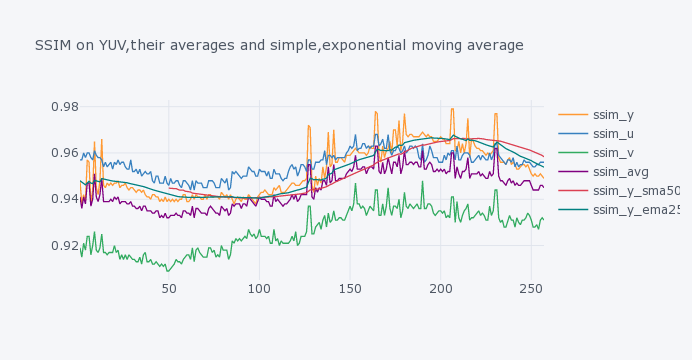

In [38]:
fig = df.iplot(title="SSIM on YUV,their averages and simple,exponential moving average", asFigure=True)
fig.update_layout(title_font=dict(size=14))

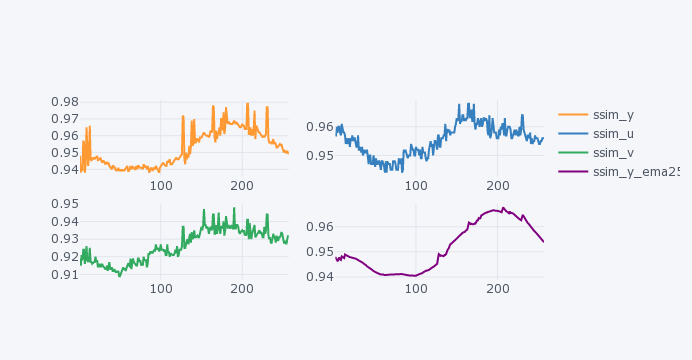

In [39]:
df.iplot(y=["ssim_y", "ssim_u", "ssim_v", "ssim_y_ema25"],subplots=True, width=2.0)

#### Initial Observations

For the given clip in this notebook which you can view [here](#Viewing-the-Test-Clip(s)) we can see is that in general the SSIM values over the luma Y\' channel are above 0.94 for the entire length of the clip and spike to near 0.98 around the second half of the clip, as the moving averages also show, falling again.

Since we had a constant quality rate factor for this test, so instead of using a fixed value quantization matrix we allow it to vary as long as it is bounded by the crf value, for the given CRF value, compression was more efficient and retained more details compared with the original on the second half of the clip.

Another observation is that the the V channel had the same fluctuations but in general had much lower SSIM values than the U channel which was consistently above the V channel SSIM value. Noteworthy is also the more subdued impact of the adaptive quantization of the CRF mode on the U channel, since its variation is much less than the Y and V channel - around 0.005 standard deviations from the mean, compared with the V channel approx. 0.009.

In [40]:
# make a copy of the dataframe, transpose, prepare for a pie chart to compare the
# standard deviation to the mean of the SSIM for the Y, U, V channels.

df2 = (df.describe()).copy(deep=True)
df2.drop(columns=["ssim_y_ema25", "ssim_y_sma50", "ssim_avg"], inplace=True)
df2 = df2.transpose()

df2.reset_index(inplace = True)
df2.head()

,index,count,mean,std,min,25%,50%,75%,max
0,ssim_y,257.0,0.952257,0.010840,0.938,0.942,0.949,0.961,0.979
1,ssim_u,257.0,0.955183,0.005449,0.944,0.951,0.956,0.959,0.968
2,ssim_v,257.0,0.926304,0.009118,0.909,0.918,0.927,0.934,0.948


In [41]:
df2.rename(columns={"index" : "ssim"}, inplace=True)

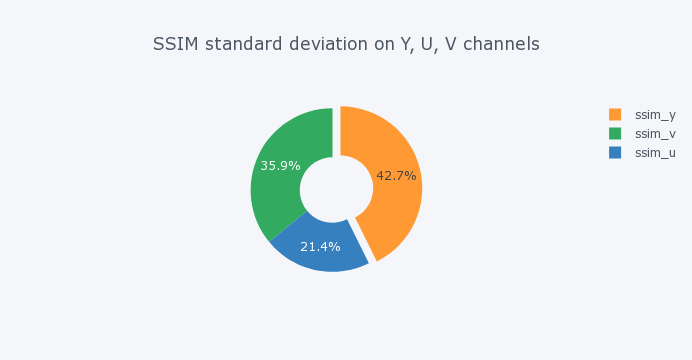

In [42]:
df2.iplot(kind="pie", labels="ssim", values="std", hole=0.4,
          pull=[0.1, 0, 0], title="SSIM standard deviation on Y, U, V channels")

It seems very clear that compression fluctuations are predominent, as expected, on the luma Y\' channel. The U and V channels fluctuate a lot less but this is expected to vary according to the scene content, albeit in a more or less decorrelated way in regard to the relative luminance Y channel.

#### Test and Export to JSON

Before proceeding with the full compression suite and analysis we'll be running the PSNR, SSIM, VMAF and VIF metrics on a reference video, export the data to a file as a JSON file, then load it and convert it to a Pandas DataFrame to avoid having to recompute everything for each compressed video.

The next step will compute the metrics for a reference video.

In [43]:
metrics_data = metrics.calc(["psnr", "ssim", "vmaf", "vif"])


psnr, ssim, vmaf, vif: 100%|██████████████████| 100/100 [00:16<00:00,  6.07it/s]


In [361]:
import ffmpeg, json, os

import encoder as enc
import media as md
import options as op

from ipywidgets import interact
from matplotlib import pyplot as plt
import ipywidgets as widgets
import numpy as np

# FFQM metrics
from ffmpeg_quality_metrics import FfmpegQualityMetrics as ffqm
# Pandas
import pandas as pd

# plotly cufflinks and configuration
import cufflinks as cf
#  ['ggplot', 'pearl', 'solar', 'space', 'white', 'polar', 'henanigans']
cf.set_config_file(theme="pearl",sharing="private",offline=True)

##### Saving a DataFrame as JSON

Export the metrics data into a JSON file for later reuse, with parameter qualification.

In [50]:
fname = media.output_files()[0].split(".")[0] + ".json"

In [51]:
metrics_json = json.dumps(metrics_data, indent = 4) 
#print(metrics_json)
media.output_dir
#
with open(fname, "w") as f:
    f.write(metrics_json)

##### Load the JSON file

Now we can load the JSON file again, and create an array of Pandas DataFrames, each one for each metric, as well as computing a simple moving average with a window of 25 frames in order to smooth the data and have a better overview of the general tendency of the results.

In [52]:
metrics_dict = {}

with open(fname, "r") as f:
    metrics_dict = json.load(f)

In [53]:
vmetrics = ["psnr", "ssim", "vmaf", "vif"]
framerate = 25

dfs = {}

for metric in vmetrics:
    df = pd.DataFrame.from_dict(metrics_dict[metric])
    
    if "n" in df.columns:
        df.rename(columns={"n" : "frame"}, inplace = True)
        df.set_index("frame", inplace = True)
    
    if metric == "psnr":
        df["psnr_y_sma25"] = df["psnr_y"].rolling(window=framerate, min_periods=framerate).mean()
        df["mse_y_sma25"] = df["mse_y"].rolling(window=framerate, min_periods=framerate).mean()
        
    elif metric == "ssim":
        df["psnr_y_sma25"] = df["ssim_y"].rolling(window=framerate, min_periods=framerate).mean()
        
    elif metric == "vmaf":
        df["vmaf_sma25"] = df["vmaf"].rolling(window=framerate, min_periods=framerate).mean()
        df["ms_ssim_sma25"] = df["ms_ssim"].rolling(window=framerate, min_periods=framerate).mean()
        df["ssim_sma25"] = df["ssim"].rolling(window=framerate, min_periods=framerate).mean()
        df["psnr_sma25"] = df["psnr"].rolling(window=framerate, min_periods=framerate).mean()
    
    else:
        pass
    
    dfs[metric] = df.copy(deep = True)  # must be deep copy

Starting by the VMAF metric and its 25 frames (1s) simple moving average.

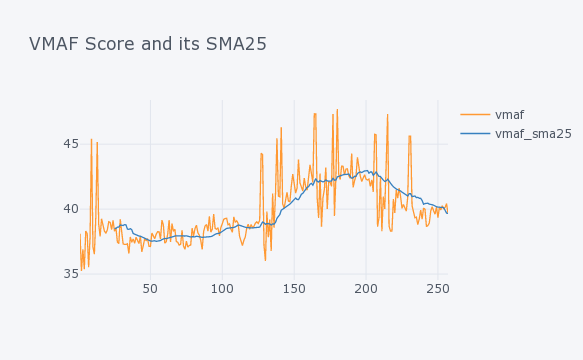

In [54]:
dfs["vmaf"].iplot(y=["vmaf", "vmaf_sma25"], title="VMAF Score and its SMA25")

##### Initial Analysis

For this test video, the VMAF score seems consistent with the earlier SSIM plots.
The video stars with relatively low quality, has a peak in perceptual quality, showing a increase in effiency of the compression, then decreases and is centered around a score of 37 roughly until halfway, and then starts increasing in quality roughly halfway with irregular fluctuations, but an overall increasing tendency, which means that less bits were needed to have a result perceptually closer to the original source material, than in the first half, where the characteristics of the scene are showing a lower SSIM and VMAF. Multi-scale SSIM might also sched some light, as well as the other objective non-perceptual metrics.

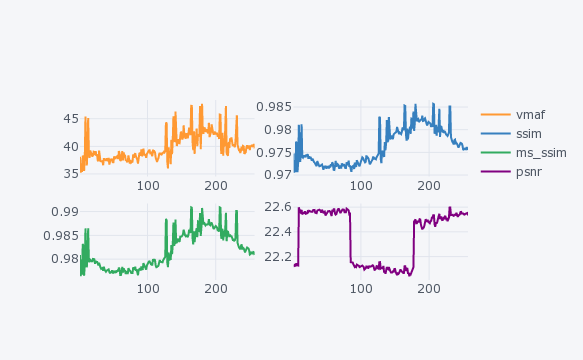

In [55]:
dfs["vmaf"].iplot(y=["vmaf", "ssim", "ms_ssim", "psnr"],subplots=True, width=2.0)

Regarding VMAF oversall score follows the same pattern as the structured similarity and multi-scale structured similarity metrics.
The PSNR metric however is a result which is relatively difficult to relate with the perceptual metrics, specially when it comes to moving images and the characteristics of the HVS, however in general a higher value reflects a higher quality reconstruction of the signal. Here it seems a value of 22.6dB is achieved until around frame 90, then drops to around 20dB, and peaks again to around 25dB from frame 180 onwards.
There seems to be some detachment from the PSNR values and the perceptual video but there's some expectation for this general detachment - that is - a change in the PSNR value doesn't necessarily imply this variation will be noticeable by the HVS.


## Video Sources

Python classes were created to automate as much as possible encoding of sources with the variations presets.
Next we'll be encoding all the input videos with the parameter sets that will be defined and commented as we go.
Check the ```mediatests.py``` file for more information.

### Encoding

In [1]:
from mediatests import MediaTests

In [2]:
mt = MediaTests()

Prepare the container with all the source material under the input directory described earlier in the media class and its methods, and assemble the fully qualified names after setting the encoding options that will be used.
Have in mind that, a large number of files, and encoding methods will take time to process and storage will also be used.

In [96]:
# Shows the default encoding sets
mt.options.encoding_sets()

{'preset': ['veryfast'],
 'crf': [18, 25, 36],
 'motion-est': ['esa', 'umh'],
 'pix_fmt': ['yuv420p', 'yuv422p', 'yuv444p']}

We'll be using h264, a CRF of 18, 25, and 36, exhaustive and multi-hexagonal searchs for motion estimation since our clip has erratic movement.
Adaptive quantization based on variance (complexity mask), automatic, and biased towards dark values is commented out to keep the number of files low. See the libx264 encoding options [here](#H.264-Compression:-x264-options:)
We'll be using diferent chroma subsampling methods as well.

In [4]:
h264_encode_set = {
    "preset" : ["veryfast"],
    "crf" : [18, 25, 36],
    "motion-est" : ["esa", "umh"],
#    "aq-mode" : [1, 2, 3],
    "pix_fmt" : ["yuv420p", "yuv422p", "yuv444p"]}

In [5]:
mt.options.insert_encoding_sets(h264_encode_set, replace=True)

In [6]:
mt.options.encoding_sets()

{'preset': ['veryfast'],
 'crf': [18, 25, 36],
 'motion-est': ['esa', 'umh'],
 'pix_fmt': ['yuv420p', 'yuv422p', 'yuv444p']}

Now prepare the structure, feeding in the source material, and building the fully qualified output filenames for each variation of the encoding set, to be stored in the compressed material structure. We'll be calling our ```encoder.py``` methods but via our ```mediatests.py``` container to iterate over this and process the videos. 
Once compressed we'll iterate over this to generate the video quality assessment in regard to the original file. Methods are provided to, once done, filter easily by codec family, parameter sets, filenames, and by video quality metrics, so that one can plot in regard to these group criteria.

In [7]:
# we can also pass a ```options.py``` instance to this method, optionally.
mt.prepare_media()

In [8]:
# show the main data structure (it's deeply nested)
mt.media_container.keys()

dict_keys(['inputdir', 'inputdata', 'outputdir', 'outputdata'])

In [9]:
mt.options.encoding_sets()

{'preset': ['veryfast'],
 'crf': [18, 25, 36],
 'motion-est': ['esa', 'umh'],
 'pix_fmt': ['yuv420p', 'yuv422p', 'yuv444p']}

### Batch Encoding and Tests

Accessing via ```mt.media_container["inputdir"]``` will show you the directory for the ingested material, with ```["inputdata"]```containing the found footage there, and the analysis of the source material - basic statistics such as frame rate, size, and so on. The keys ```["outputdir"]``` point to the destination for the compressed files, and ```["outputdata"]``` shows a very deeply nested structure containing the variations.
You can query it in order to have an idea of what's going to be generated in the encoding step next. Beware of [combinatorial explosion](https://en.wikipedia.org/wiki/Combinatorial_explosion).

<div class="alert alert-block alert-warning">
<b>Attention:</b> By default encoding videos is set to print the output, unless you pass the optional parameter <b>debug</b> as <b>False</b>. Have in mind that encoding the videos takes <b>some time</b>. Beware of using too many options, options sets, combinations.
</div>

In [10]:
# the default if you call mt.encode_videos(), print the output files
#mt.encode_videos(debug=True)

# REALLY encodede now. GPU encoders do their job but it still takes time
#mt.encode_videos(debug=False, progress=True)

We now have the h264 variations for the options set above. We need to compute the video quality metrics for each of them, and store them into respective json files. Presently the automated test feeding is not yet complete, but the full automated encoding is, as well as the actual test metrics.
We'll proceed to filter some files by a criteria to compare the dataframes.

In [11]:
# make a deep copy of the data since we'll be filtering data in-place
import copy as cp
mt2 = cp.deepcopy(mt)

Filtering by filename first, we'll narrow to a file with random chaotic motion, then to the ```libx264``` codec, then to the ```crf``` metric.

In [16]:
# Filter by input file
mt.outputdata = mt.by_file("light_orbitals.mkv")

In [15]:
# Filter by codec
mt.outputdata = mt.by_codec("libx264")

In [14]:
# Filter by encoding parameter in the parameter sets, in this case, CRF
mt.outputdata = mt.by_paramset("crf")

In [18]:
mt.outputdata

{'light_orbitals.mkv': {'libx264': {'crf': ['light_orbitals_-_preset_veryfast__crf_18__motion-est_esa__pix_fmt_yuv420p.mkv',
    'light_orbitals_-_preset_veryfast__crf_18__motion-est_esa__pix_fmt_yuv422p.mkv',
    'light_orbitals_-_preset_veryfast__crf_18__motion-est_esa__pix_fmt_yuv444p.mkv',
    'light_orbitals_-_preset_veryfast__crf_18__motion-est_umh__pix_fmt_yuv420p.mkv',
    'light_orbitals_-_preset_veryfast__crf_18__motion-est_umh__pix_fmt_yuv422p.mkv',
    'light_orbitals_-_preset_veryfast__crf_18__motion-est_umh__pix_fmt_yuv444p.mkv',
    'light_orbitals_-_preset_veryfast__crf_25__motion-est_esa__pix_fmt_yuv420p.mkv',
    'light_orbitals_-_preset_veryfast__crf_25__motion-est_esa__pix_fmt_yuv422p.mkv',
    'light_orbitals_-_preset_veryfast__crf_25__motion-est_esa__pix_fmt_yuv444p.mkv',
    'light_orbitals_-_preset_veryfast__crf_25__motion-est_umh__pix_fmt_yuv420p.mkv',
    'light_orbitals_-_preset_veryfast__crf_25__motion-est_umh__pix_fmt_yuv422p.mkv',
    'light_orbitals_-_pre

In [19]:
# Filter by fully qualified output name, FQN
filteredfile = mt.by_fqn_output("light_orbitals_-_preset_veryfast__crf_18__motion-est_esa__pix_fmt_yuv422p.mkv")
filteredfile

{'light_orbitals.mkv': {'libx264': {'crf': ['light_orbitals_-_preset_veryfast__crf_18__motion-est_esa__pix_fmt_yuv422p.mkv']}}}

In [29]:
mt.outputdata

{'light_orbitals.mkv': {'libx264': {'crf': ['light_orbitals_-_preset_veryfast__crf_18__motion-est_esa__pix_fmt_yuv420p.mkv',
    'light_orbitals_-_preset_veryfast__crf_18__motion-est_esa__pix_fmt_yuv422p.mkv',
    'light_orbitals_-_preset_veryfast__crf_18__motion-est_esa__pix_fmt_yuv444p.mkv',
    'light_orbitals_-_preset_veryfast__crf_18__motion-est_umh__pix_fmt_yuv420p.mkv',
    'light_orbitals_-_preset_veryfast__crf_18__motion-est_umh__pix_fmt_yuv422p.mkv',
    'light_orbitals_-_preset_veryfast__crf_18__motion-est_umh__pix_fmt_yuv444p.mkv',
    'light_orbitals_-_preset_veryfast__crf_25__motion-est_esa__pix_fmt_yuv420p.mkv',
    'light_orbitals_-_preset_veryfast__crf_25__motion-est_esa__pix_fmt_yuv422p.mkv',
    'light_orbitals_-_preset_veryfast__crf_25__motion-est_esa__pix_fmt_yuv444p.mkv',
    'light_orbitals_-_preset_veryfast__crf_25__motion-est_umh__pix_fmt_yuv420p.mkv',
    'light_orbitals_-_preset_veryfast__crf_25__motion-est_umh__pix_fmt_yuv422p.mkv',
    'light_orbitals_-_pre

In [59]:
testfiles = []

for k, v in mt.outputdata.items():
    for i, j in v.items():
        for x, y in j.items():
            testfiles.extend(
                [os.path.join(mt.media_container["outputdir"], x) for x in y]
            )

In [61]:
srcfiles = []
for k, v in mt.outputdata.items():
    srcfiles.append(os.path.join(mt.media_container["inputdir"], k))

In [62]:
srcfiles

['/home/cgwork/Downloads/Masters/Tecnologias_Comunicacao_Multimedia_TCM/Work/videos/original/light_orbitals.mkv']

In [63]:
from ffmpeg_quality_metrics import FfmpegQualityMetrics as ffqm
import pandas as pd

In [102]:
# prep storage and metrics
# testio = {srcfiles[0] : testfiles}
testresults = []
tests = ["vmaf", "ssim", "psnr"]

In [121]:
# only one source file, so no need to iterate over the entire footage list
inputfile = srcfiles[0]

# Finally run the tests, store into the array, and save as JSON files to
# avoid having to run expensive tests again
for compressedfile in testfiles:
    metrics = ffqm(srcfile, compressedfile, progress = False)
    metrics_data = metrics.calc(tests)
    fname, ext = os.path.splitext(compressedfile)
    fname = fname + ".json"
    mt.videoqtests.save_json(metrics_data, fname)
    testresults.append(metrics_data)
    

### Building a DataFrame to Plot

Now we have an array with the test results for the footage and we can start seeing the impact of the options choosen in the perceptual and objective measures. Load the JSON for illustration purposes, build a tuple of 2 or 3 elements, element 0 for the input file if needed, 1 for test file, 2 for the test results dictionary with the metrics used, in this test, **SSIM**, **VMAF**, **PSNR**

In [164]:
# Load JSON from results
testresults = []

for compressedfile in testfiles:
    fname, ext = os.path.splitext(compressedfile)
    fname = fname + ".json"
    testresults.append(mt.videoqtests.load_json(fname))


In [252]:
# f = [os.path.basename(x) for x in testfiles]
framerate,_ = mt.media_container["inputdata"][srcfiles[0]]["r_frame_rate"].split("/")
framerate=int(framerate)
dfs = {}

Build a nested dictionary to convert to a multi-index dataframe.

In [500]:
dfs = {}

for i, c in enumerate(testfiles):
    df = pd.DataFrame.from_dict(testresults[i]["vmaf"])
    if "n" in df.columns:
        df.rename(columns={"n" : "frame"}, inplace=True)
        df.set_index("frame", inplace=True)
    dfs[os.path.basename(c)] = df.copy(deep=True)
    
reformed_dict = {}
for outerk, innerd in dfs.items():
    for innerk, values in innerd.items():
        reformed_dict[(outerk, innerk)] = values
        
mdf = pd.DataFrame(reformed_dict)

In [501]:
# file to access for test
nfile = "light_orbitals_-_preset_veryfast__crf_18__motion-est_esa__pix_fmt_yuv420p.mkv"

In [502]:
mdf2 = mdf.copy(deep = True)

In [503]:
mdf2[nfile]

,psnr,integer_motion2,integer_motion,integer_adm2,integer_adm_scale0,integer_adm_scale1,integer_adm_scale2,integer_adm_scale3,ssim,integer_vif_scale0,integer_vif_scale1,integer_vif_scale2,integer_vif_scale3,ms_ssim,vmaf
frame,,,,,,,,,,,,,,,
1,22.173126,0.000000,0.000000,0.822708,0.889201,0.827274,0.790936,0.776726,0.981752,0.659667,0.828004,0.841630,0.850765,0.987508,42.908559
2,22.176135,2.143594,2.143594,0.804705,0.877725,0.810931,0.770919,0.751866,0.978929,0.616752,0.809357,0.825326,0.837393,0.984524,40.608449
3,22.186353,2.174164,2.229993,0.809113,0.881307,0.816285,0.772766,0.756687,0.979879,0.630125,0.813490,0.830120,0.843222,0.985550,41.995908
4,22.169560,2.141280,2.174164,0.803830,0.877931,0.811109,0.769427,0.750504,0.979165,0.620198,0.812802,0.828150,0.837903,0.984864,40.530280
5,22.173912,0.000000,2.141280,0.816986,0.888836,0.825354,0.782443,0.768642,0.981941,0.688541,0.831151,0.841455,0.848130,0.987614,41.508192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,22.596779,2.130053,2.130053,0.817084,0.885460,0.819984,0.785397,0.771735,0.982546,0.654402,0.836419,0.848781,0.853865,0.987648,44.687808
254,22.594971,2.106853,2.349652,0.816119,0.885890,0.822219,0.782842,0.768972,0.982392,0.655843,0.834218,0.847135,0.854174,0.987610,44.444005
255,22.599585,2.068774,2.106853,0.817749,0.886496,0.824338,0.784062,0.770092,0.982834,0.655904,0.836654,0.849826,0.859685,0.987958,45.186619


Example file, ```light_orbitals.mkv```, with random chaotic movement, light saturated cycling colors. With 4\:2\:0 chroma sampling we should expect to see degradation since we only have 2 chroma pixels per 4 luma pixels for every other odd or even line.

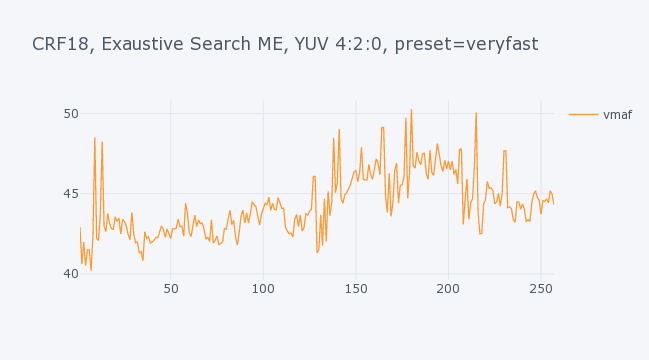

In [516]:
dfs[nfile].iplot(y=["vmaf"], title="CRF18, Exaustive Search ME, YUV 4:2:0, preset=veryfast", legend="foo")

In [494]:
# we need figure objects
import plotly.graph_objects as go

### Filtering For Plots

It would be advantageous to filter by chroma sampling since in these cases the difference is dramatic. We'll see below all the files encoded with constant rate factors, that is, the quantization matrix was allowed to vary as long as the quality factor remained the same.
Clicking in one of the trace legends twice rapidly will hide all traces, then one can enable them one by one. This will allow one to for instance, group the traces by chroma sampling, in order to have a better appreciation of the impact of the motion estimation.

In [573]:
# from plotly get a figure object, for the preset layout
fig = dfs[nfile].iplot(y=["vmaf"], asFigure=True)
data, flayout = fig["data"], fig["layout"]

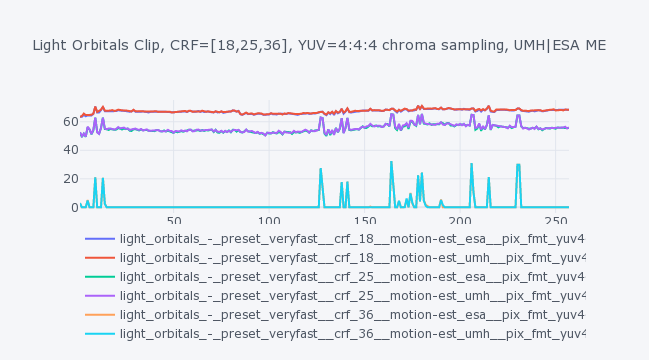

In [574]:
fig = go.Figure()
fig["layout"] = flayout

# Plot the files with CRF=18 only
for k, v in dfs.items():
    #fig.add_trace(go.Scatter(x=["frame"], y=["psnr"]))
    if "yuv444p" in k:
        fig.add_trace(go.Scatter(x=dfs[k].index.values, y=dfs[k]["vmaf"], name=str(k)))
    #print(k)
fig.update_layout(title=dict(font=dict(size=14),text="Light Orbitals Clip, CRF=[18,25,36], YUV=4:4:4 chroma sampling, UMH|ESA ME"),legend=dict(orientation="h"))

From the initial glance we can see that the files encoded with a CRF value of 36 have very bad VMAF scores. Inspecting the file shows terrible degradation in image quality. Visible macroblocks, excessive quantization.

If you hide the CRF=36 plot traces shows more nuanced results (click on the trace legend color in the plot to toggle its visibility).

With a CRF of 25, the VMAF scores fluctuates as we saw earlier in the first plots. Higher complexity and lower quality in the first half, then spikes in the VMAF score and a smoother climb and progression in the 2nd half.

The **esa** (exhaustive search adaptive) motion estimation method is a *smarter* brute-force method searching the entire motion space within the motion estimation window. It still underperformed consistently, albeit not by much, the **umh** multi-hexagen pattern method motion estimation method. This method was created for harder to find motion vectors and it seems to have benefits.

Going to the CRF=18 trace plots, the difference between the motion estimation methods is stronger, and **umh** seems to be advantageous.

From this we can immediatly discard anything higher than CRF=25 in this clip.
The arithmetic means of VMAF in the YUV 4\:4\:4, 4\:2\:0 clips are:

In [575]:
for k, v in dfs.items():
    if "crf_36" in k:
        continue
    print(f"Clip: {k} VMAF mean = {v['vmaf'].mean()}")

Clip: light_orbitals_-_preset_veryfast__crf_18__motion-est_esa__pix_fmt_yuv420p.mkv VMAF mean = 44.30000864202334
Clip: light_orbitals_-_preset_veryfast__crf_18__motion-est_esa__pix_fmt_yuv422p.mkv VMAF mean = 44.23868481322957
Clip: light_orbitals_-_preset_veryfast__crf_18__motion-est_esa__pix_fmt_yuv444p.mkv VMAF mean = 67.27321896887159
Clip: light_orbitals_-_preset_veryfast__crf_18__motion-est_umh__pix_fmt_yuv420p.mkv VMAF mean = 44.759980926070035
Clip: light_orbitals_-_preset_veryfast__crf_18__motion-est_umh__pix_fmt_yuv422p.mkv VMAF mean = 44.689372976653694
Clip: light_orbitals_-_preset_veryfast__crf_18__motion-est_umh__pix_fmt_yuv444p.mkv VMAF mean = 67.49915161867705
Clip: light_orbitals_-_preset_veryfast__crf_25__motion-est_esa__pix_fmt_yuv420p.mkv VMAF mean = 36.2753383385214
Clip: light_orbitals_-_preset_veryfast__crf_25__motion-est_esa__pix_fmt_yuv422p.mkv VMAF mean = 36.01070726070039
Clip: light_orbitals_-_preset_veryfast__crf_25__motion-est_esa__pix_fmt_yuv444p.mkv VMA

### Reading the VMAF Score

As mentioned earlier and referred to in the [NetFlix Technical Blog](https://netflixtechblog.com/vmaf-the-journey-continues-44b51ee9ed12)

> VMAF scores range from 0 to 100, with 0 indicating the lowest quality, and 100 the highest. A good way to think about a VMAF score is to linearly map it to the human opinion scale under which condition the training scores are obtained. As an example, the default model v0.6.1 is trained using scores collected by the Absolute Category Rating (ACR) methodology using a 1080p display with viewing distance of 3H. Viewers voted the video quality on the scale of “bad”, “poor”, “fair”, “good” and “excellent”, and roughly speaking, “bad” is mapped to the VMAF scale 20 and “excellent” to 100. Thus, a VMAF score of 70 can be interpreted as a vote between “good” and “fair” by an average viewer under the 1080p and 3H condition. Another factor to consider is that the best and the worst votes a viewer can give is calibrated by the highest- and lowest-quality videos in the entire set (during training, and before the actual test starts, subjects are typically accustomed to the experiment’s scale). In the case of the default model v0.6.1, the best and the worst videos are the ones compressed at 1080p with a low quantization parameter (QP) and the ones at 240p with a high QP, respectively.

According to this criteria, anything but the YUV 4:4:4 sampled clip with a CRF of 18 is discarded. However according to [Twitter Engineering](https://blog.twitter.com/engineering/en_us/topics/infrastructure/2020/introducing-vmaf-percentiles-for-video-quality-measurements) one shouldn't give too much credence to the mean since it might hide difficult to encode frames, choosing percentiles instead.

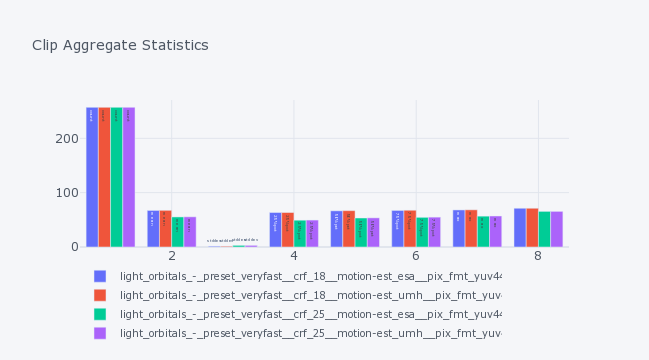

In [683]:
#for k, v in dfs.items():
#    if ("crf_18" in k or "crf_25" in k) and "yuv444p" in k:
#        #print(f"VMAF overall statistics: {dfs[k]['vmaf'].describe()}")
#        dfs[k]["vmaf"].describe().iplot(kind="bar")
        
fig = go.Figure()
fig["layout"] = flayout

for k, v in dfs.items():
    if ("crf_18" in k or "crf_25" in k) and "yuv444p" in k:
        fig.add_trace(
            go.Bar(x=dfs[k]["vmaf"].index, y=dfs[k]["vmaf"].describe(),
                   name=str(k),
                   text=["count", "mean", "stddev", "25% pct", "50% pct", "75% pct", "max"],
))
        
        
fig.update_layout(title=dict(font=dict(size=14),
                             text="Clip Aggregate Statistics"),
                  legend=dict(orientation="h",font=dict(size=10)),
                 )
#fig.update_layout(legend_tracegroupgap=2)

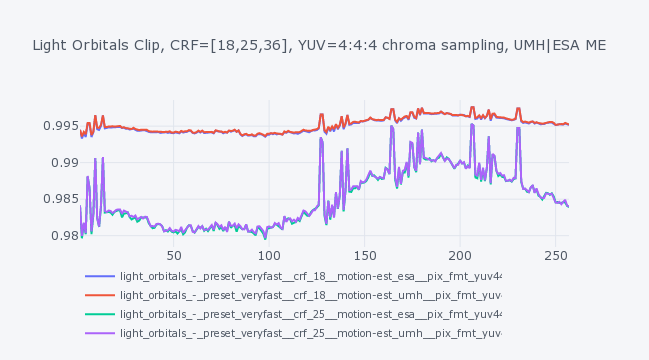

In [607]:
fig = go.Figure()
fig["layout"] = flayout

for k, v in dfs.items():
    if ("crf_18" in k or "crf_25" in k) and "yuv444p" in k:
        fig.add_trace(
            go.Scatter(x=dfs[k].index.values, y=dfs[k]["ms_ssim"], name=str(k)))
fig.update_layout(title=dict(font=dict(size=14),text="Light Orbitals Clip, CRF=[18,25,36], YUV=4:4:4 chroma sampling, UMH|ESA ME"),legend=dict(orientation="h",font=dict(size=10)))
#fig.update_layout(legend_tracegroupgap=2)

The multi-scale structural similarity index shows consistent results. A value of 1.0 is only reached in two identical data sets, and as such, indicates perfect structural similarity.
The PSNR values are added as well.

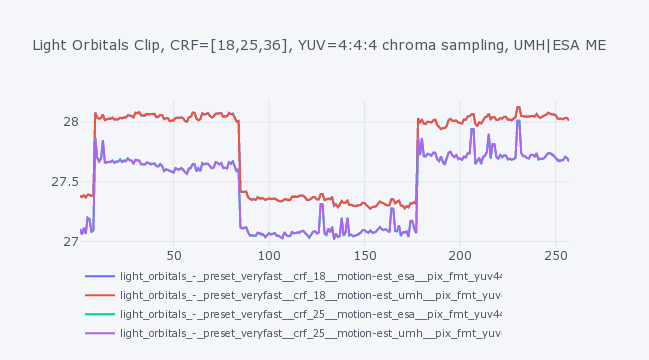

In [608]:
fig = go.Figure()
fig["layout"] = flayout

for k, v in dfs.items():
    if ("crf_18" in k or "crf_25" in k) and "yuv444p" in k:
        fig.add_trace(
            go.Scatter(x=dfs[k].index.values, y=dfs[k]["psnr"], name=str(k)))
fig.update_layout(title=dict(font=dict(size=14),text="Light Orbitals Clip, CRF=[18,25,36], YUV=4:4:4 chroma sampling, UMH|ESA ME"),legend=dict(orientation="h",font=dict(size=10)))
#fig.update_layout(legend_tracegroupgap=2)

The results when viewing the structured similarity index matrix (**SSIM**) and its multi-scale (**MS-SSIM**) counterpart are equivalent.

Typical values are between 30dB and 50dB for 8bit sources, which is the case.
Since PSNR is
${\small PSNR} = 10 \cdot \log_{10}{\frac{MAX_{i}^{2}}{MSE}}$, with $MAX_{i}$ the maximum pixel code value of the image, two identical images would result in a error of 0, a denominator of 0, and $\lim_{mse\to 0}{\left [ 10 \cdot \log_{10}{\frac{MAX_{i}^{2}}{MSE}}\right ]} = \infty$
It shows values below 30dB, but unlike [PSNR-HVS-M](http://www.ponomarenko.info/psnrhvsm.htm) it doesn't take into account the characteristics of the HVS.
Its variation is small as well, around $\sigma \approx 0.32$ from its 

In [624]:
for k, v in dfs.items():
    if ("crf_18" in k or "crf_25" in k) and "yuv444p" in k:
        print(f'Mean={v["psnr"].mean():.4f}, stdev={v["psnr"].std():.4f}')

Mean=27.7631, stdev=0.3405
Mean=27.7633, stdev=0.3404
Mean=27.4523, stdev=0.3018
Mean=27.4524, stdev=0.3010


In [626]:
dfs[nfile].columns

Index(['psnr', 'integer_motion2', 'integer_motion', 'integer_adm2',
       'integer_adm_scale0', 'integer_adm_scale1', 'integer_adm_scale2',
       'integer_adm_scale3', 'ssim', 'integer_vif_scale0',
       'integer_vif_scale1', 'integer_vif_scale2', 'integer_vif_scale3',
       'ms_ssim', 'vmaf'],
      dtype='object')

In [636]:
dfs[nfile]["vmaf"].iloc["harmonic_mean"]

TypeError: Cannot index by location index with a non-integer key

In [650]:
for k, v in dfs.items():
    if ("crf_18" in k or "crf_25" in k) and "yuv444p" in k:
        print(f"VMAF overall statistics: {dfs[k]['vmaf'].describe()}")
#        dfs[k]["vmaf"].describe().iplot(kind="bar")

VMAF overall statistics: count    257.000000
mean      67.273219
std        1.364006
min       63.456621
25%       66.545157
50%       67.285177
75%       68.194115
max       71.299490
Name: vmaf, dtype: float64
VMAF overall statistics: count    257.000000
mean      67.499152
std        1.314770
min       63.468111
25%       66.867068
50%       67.635572
75%       68.430944
max       71.299490
Name: vmaf, dtype: float64
VMAF overall statistics: count    257.000000
mean      55.311850
std        3.007986
min       49.299099
25%       53.366975
50%       54.584050
75%       56.750523
max       65.559404
Name: vmaf, dtype: float64
VMAF overall statistics: count    257.000000
mean      55.514779
std        2.966055
min       49.562234
25%       53.605196
50%       54.927812
75%       57.031198
max       65.559404
Name: vmaf, dtype: float64
